# Use DeepCCA and MCA to transform ADNI features

## Importing Stuff:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import torch
import torch.nn as nn
from linear_cca import linear_cca
from torch.utils.data import BatchSampler, SequentialSampler
from DeepCCAModels import DeepCCA
from main import Solver
from utils import load_data, svm_classify
from objectives import cca_loss
try:
    import cPickle as thepickle
except ImportError:
    import _pickle as thepickle
from IPython.display import display
import pickle
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import sklearn.model_selection as model_selection
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import pprint

## Read the Data:

The transformed through LR data is located at "./DATA/Linearly_Transformed_Unique_Dataset.pkl".

The transformed through FAMD data is located at "./DATA/FAMD_Transformed_data_10_components.pkl"

In [3]:
# Read the data transformed through the Regressional Analysis:
lr_data = pd.read_pickle("./DATA/Linearly_Transformed_Unique_Dataset.pkl")
print(lr_data.shape)
lr_data.head()

(1302, 209)


,PTID,MRID,Date,Age,Sex,DLICV_baseline,APOE4_Alleles,APOE_Genotype,Diagnosis_nearest_2.0,MUSE_Volume_4,...,rs111278892,rs3752246,rs4147929,rs41289512,rs3865444,rs6024870,rs6014724,rs7274581,rs429358,Diagnosis_nearest_2.0_cat
0,002_S_0295,002_S_0295_2006-04-18,2006-04-18,84.742466,0,1485405.375,1.0,E3/E4,CN,-401.428503,...,1,1,1,0,0,0,0,0,1,0
9,002_S_0413,002_S_0413_2006-05-02,2006-05-02,76.283562,1,1364116.000,0.0,E3/E3,CN,596.355045,...,0,1,1,0,1,0,0,0,0,0
24,002_S_0559,002_S_0559_2006-05-23,2006-05-23,79.223288,0,1570479.625,1.0,E3/E4,CN,224.874560,...,0,0,0,0,1,0,0,0,0,0
31,002_S_0619,002_S_0619_2006-06-01,2006-06-01,77.447945,0,1859348.250,2.0,E4/E4,Dementia,2633.277779,...,0,0,0,1,1,0,0,0,2,1
45,002_S_0729,002_S_0729_2006-07-17,2006-07-17,65.056164,1,1166961.750,1.0,E3/E4,MCI,256.289641,...,0,0,0,1,1,0,0,0,1,2


In [4]:
mca_data = np.load("./DATA/MCA_Transformed_Genetic_data_10_components.pkl.npy")
print(mca_data.shape)
print(mca_data)

(1302, 10)
[[ 0.02371735  0.00758166  0.03124097 ...  0.02007631 -0.03371415
   0.02345717]
 [ 0.01051906 -0.02912091 -0.02414146 ... -0.03836163  0.01941386
   0.05144005]
 [ 0.00313658  0.02024018  0.03054364 ... -0.01525235 -0.01290234
   0.03417399]
 ...
 [-0.00580048  0.00667212  0.03939653 ...  0.01200354  0.00510257
  -0.04572104]
 [ 0.06722299 -0.00955109 -0.08351047 ...  0.02180382  0.01885345
  -0.038522  ]
 [ 0.03114945  0.02050712  0.03119218 ...  0.01215095 -0.03140962
   0.02663309]]


### Create the Dataset:

In [5]:
# Create a new dataset and drop the imaging and genetic data:
c = list(lr_data.columns)
genetic_columns = c[c.index("rs4575098"):c.index("rs429358")+1]
columns_to_drop = genetic_columns
print(lr_data.shape)
mca = lr_data.drop(labels = columns_to_drop, axis=1)

# Embed them into the new dataset:
component_labels = ["component_"+str(x+1) for x in range(mca_data.shape[1])] 
mca[component_labels] = mca_data
print(mca.shape)
mca.head()

(1302, 209)
(1302, 165)


,PTID,MRID,Date,Age,Sex,DLICV_baseline,APOE4_Alleles,APOE_Genotype,Diagnosis_nearest_2.0,MUSE_Volume_4,...,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10
0,002_S_0295,002_S_0295_2006-04-18,2006-04-18,84.742466,0,1485405.375,1.0,E3/E4,CN,-401.428503,...,0.023717,0.007582,0.031241,-0.002605,0.021999,-0.002884,0.013514,0.020076,-0.033714,0.023457
9,002_S_0413,002_S_0413_2006-05-02,2006-05-02,76.283562,1,1364116.000,0.0,E3/E3,CN,596.355045,...,0.010519,-0.029121,-0.024141,0.002656,-0.018639,-0.021598,-0.009398,-0.038362,0.019414,0.051440
24,002_S_0559,002_S_0559_2006-05-23,2006-05-23,79.223288,0,1570479.625,1.0,E3/E4,CN,224.874560,...,0.003137,0.020240,0.030544,0.036016,0.083296,0.002379,-0.020733,-0.015252,-0.012902,0.034174
31,002_S_0619,002_S_0619_2006-06-01,2006-06-01,77.447945,0,1859348.250,2.0,E4/E4,Dementia,2633.277779,...,-0.047720,-0.001291,-0.025738,0.033784,-0.058591,0.001219,0.015067,-0.026107,0.044011,0.042946
45,002_S_0729,002_S_0729_2006-07-17,2006-07-17,65.056164,1,1166961.750,1.0,E3/E4,MCI,256.289641,...,-0.004070,-0.009009,0.018683,0.034929,0.039583,-0.002678,-0.030461,-0.027636,-0.024174,0.028044


##  Building, training the DCCA Model

### Create the 2 views:

In [21]:
# View 1:
view_1 = mca.loc[:,"MUSE_Volume_4":"MUSE_Volume_207"]

# View 2:
view_2 = mca.loc[:,"component_"+str(1):"component_"+str(mca_data.shape[1])]

print("View 1:")
display(view_1.head())
print("View 2:")
display(view_2.head())

View 1:


,MUSE_Volume_4,MUSE_Volume_11,MUSE_Volume_23,MUSE_Volume_30,MUSE_Volume_31,MUSE_Volume_32,MUSE_Volume_35,MUSE_Volume_36,MUSE_Volume_37,MUSE_Volume_38,...,MUSE_Volume_198,MUSE_Volume_199,MUSE_Volume_200,MUSE_Volume_201,MUSE_Volume_202,MUSE_Volume_203,MUSE_Volume_204,MUSE_Volume_205,MUSE_Volume_206,MUSE_Volume_207
0,-401.428503,-475.082401,-38.009137,-25.646775,75.669198,126.590353,124.482040,54.813183,29.901574,4088.590752,...,789.359109,-170.422388,-1543.880458,-1674.618225,632.563713,-531.585707,-39.623451,260.649954,-115.085767,-81.954942
9,596.355045,-177.499304,34.866428,-42.623326,36.073837,53.399103,-914.581355,-108.931623,124.883198,-972.814733,...,1335.363413,2649.942277,1411.230818,31.346635,-1267.747385,117.940453,-149.481247,-535.823873,-40.431290,-470.993059
24,224.874560,1110.220538,134.798531,135.858384,109.271915,29.323465,1704.716715,-284.353318,-15.319536,-1099.592092,...,-1719.736333,-2192.002637,1513.234184,523.058557,1603.211181,2422.347525,218.967561,-66.321636,-200.393450,-107.128517
31,2633.277779,703.512999,-165.584181,-128.673356,-351.196493,-369.996116,-3669.094187,-871.937556,-752.247876,-503.572274,...,-616.963790,603.136888,-608.460701,-1332.047832,-3012.228200,-2804.914271,-791.597461,-822.562965,-356.240988,-118.945277
45,256.289641,599.953746,10.855725,32.230306,-150.404626,-107.055211,472.978958,649.045998,130.401624,-85.434102,...,-317.885924,-670.024556,62.647813,986.709609,-1459.773538,-1367.048968,-141.267965,-197.021311,-217.041629,-277.950585


View 2:


,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10
0,0.023717,0.007582,0.031241,-0.002605,0.021999,-0.002884,0.013514,0.020076,-0.033714,0.023457
9,0.010519,-0.029121,-0.024141,0.002656,-0.018639,-0.021598,-0.009398,-0.038362,0.019414,0.051440
24,0.003137,0.020240,0.030544,0.036016,0.083296,0.002379,-0.020733,-0.015252,-0.012902,0.034174
31,-0.047720,-0.001291,-0.025738,0.033784,-0.058591,0.001219,0.015067,-0.026107,0.044011,0.042946
45,-0.004070,-0.009009,0.018683,0.034929,0.039583,-0.002678,-0.030461,-0.027636,-0.024174,0.028044


### Parameters:

In [22]:
device = torch.device('cpu')
outdim_size = 150
input_shape1 = view_1.shape[1]
input_shape2 = view_2.shape[1]
layer_sizes1 = [256, 1024, 1024, outdim_size]
layer_sizes2 = [256, 1024, 1024, outdim_size]
learning_rate = 1e-3
epoch_num = 400
epoch_log_freq = 50
batch_size = 1000
reg_par = 1e-3
# the path to save the final learned features, as DCCA-o-d.
save_to = './DATA/ADNI_MCA_DCCA_features_'+str(outdim_size)+'_'+str(len(layer_sizes1)-1)+'.pkl'
use_all_singular_values = False
apply_linear_cca = True

### Training:

In [23]:
# Convert the pandas dataframe to numpy arrays for pytorch:
view_1_n = view_1.to_numpy()
view_2_n = view_2.to_numpy()
# Scramble the datapoints for randomness:
indices = np.arange(view_1_n.shape[0])
# np.random.shuffle(indices)
view_1_n = view_1_n[indices]
view_2_n = view_2_n[indices].astype(np.float64) # DeepCCA MLP requires double type

print(view_1_n.shape, type(view_1_n), view_1_n.dtype)
print(view_2_n.shape, type(view_2_n), view_2_n.dtype)

view_1_t = torch.from_numpy(view_1_n)
print(view_1_t.shape, type(view_1_t))
view_2_t = torch.from_numpy(view_2_n)
print(view_2_t.shape, type(view_2_t))

data1 = view_1_t
data2 = view_2_t

model = DeepCCA(layer_sizes1, layer_sizes2, input_shape1, input_shape2, outdim_size, use_all_singular_values, device=device).double()
solver = Solver(model, linear_cca(), outdim_size, epoch_num, batch_size, learning_rate, reg_par, device=device, epoch_log_freq=epoch_log_freq, log=False)

s_1, s_2 = data1.shape[0], data2.shape[0]
# Split the dataset into training, validation and testing (75%-15%-10%):
train1, train2 = data1[0:int(s_1 * 0.75)], data2[0:int(s_2 * 0.75)]
val1, val2 = data1[int(s_1 * 0.75):int(s_1 * 0.9)], data2[int(s_2 * 0.75):int(s_2 * 0.9)]
test1, test2 = data1[int(s_1 * 0.9):], data2[int(s_2 * 0.9):]

loss = solver.fit(train1, train2, val1, val2, test1, test2, checkpoint=None)
training_losses, val_losses = solver.get_losses()

(1302, 145) <class 'numpy.ndarray'> float64
(1302, 10) <class 'numpy.ndarray'> float64
torch.Size([1302, 145]) <class 'torch.Tensor'>
torch.Size([1302, 10]) <class 'torch.Tensor'>


[ INFO : 2022-04-12 20:20:46,382 ] - Epoch 1/400 - time: 0.34 - training_loss: -31.3184 - val_loss: -4.8450
[ INFO : 2022-04-12 20:21:03,606 ] - Epoch 51/400 - time: 0.31 - training_loss: -112.6208 - val_loss: -51.6319
[ INFO : 2022-04-12 20:21:22,596 ] - Epoch 101/400 - time: 0.31 - training_loss: -128.1204 - val_loss: -120.1933
[ INFO : 2022-04-12 20:21:42,747 ] - Epoch 151/400 - time: 0.39 - training_loss: -134.2537 - val_loss: -120.9658
[ INFO : 2022-04-12 20:22:00,634 ] - Epoch 201/400 - time: 0.41 - training_loss: -137.5194 - val_loss: -121.2379
[ INFO : 2022-04-12 20:22:20,001 ] - Epoch 251/400 - time: 0.52 - training_loss: -139.5448 - val_loss: -121.6705
[ INFO : 2022-04-12 20:22:38,988 ] - Epoch 301/400 - time: 0.42 - training_loss: -140.9179 - val_loss: -121.6478
[ INFO : 2022-04-12 20:23:00,409 ] - Epoch 351/400 - time: 0.41 - training_loss: -141.9286 - val_loss: -122.2218
[ INFO : 2022-04-12 20:23:21,024 ] - loss on validation data: -122.4970
[ INFO : 2022-04-12 20:23:21,09

### Plotting the losses:

[-145.333  -94.859]

<class 'numpy.ndarray'>
(1302, 150)
<class 'numpy.ndarray'>
(1302, 150)


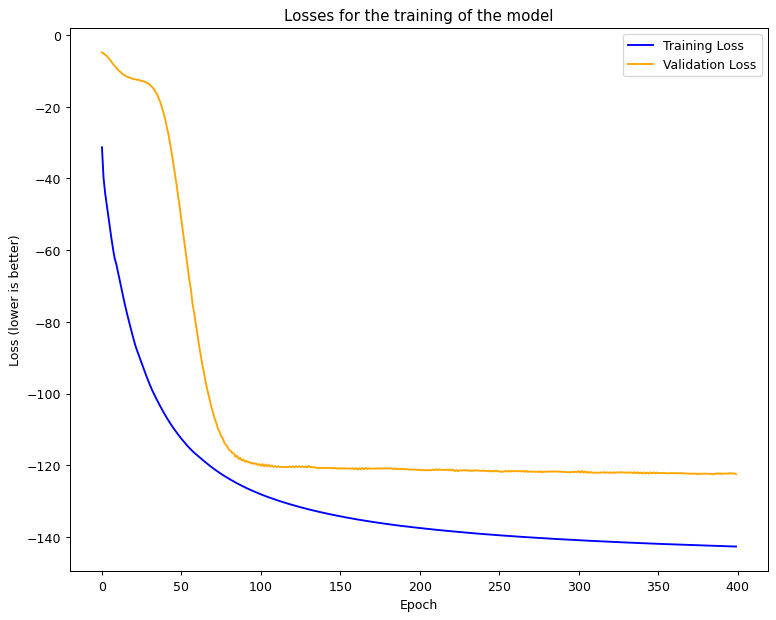

In [24]:
set_size = [0, 
            train1.size(0), 
            train1.size(0) + val1.size(0), 
            train1.size(0) + val1.size(0) + test1.size(0)]

losses, outputs = solver._get_outputs(data1, data2)
losses = np.round(losses,3)
print(losses)

print()

print(type(outputs[0]))
print(outputs[0].shape)
print(type(outputs[1]))
print(outputs[1].shape)

x = np.arange(len(training_losses))
plt.figure(figsize=(10, 8), dpi=90)
plt.plot(x, training_losses, color='blue', label="Training Loss")
plt.plot(x, val_losses, color='orange', label="Validation Loss")
plt.title("Losses for the training of the model")
plt.xlabel("Epoch")
plt.ylabel("Loss (lower is better)")
plt.legend()

## Testing the model:

### Testing the Correlation between inputs and outputs of the deep Network:

In [25]:
from sklearn.cross_decomposition import CCA

print("CCA on input data:")
X = data1
Y = data2
cca = CCA(n_components=10)
cca.fit(X, Y)
X_c, Y_c = cca.transform(X, Y)
print(cca.score(X, Y))

print("CCA on output data:")
X = outputs[0]
Y = outputs[1]
cca = CCA(n_components=150,max_iter=10000)
cca.fit(X, Y)
X_c, Y_c = cca.transform(X, Y)
# The best possible score is 1.0 and it can be negative 
# (because the model can be arbitrarily worse)
print(cca.score(X, Y)) 

CCA on input data:
0.059720376659286464
CCA on output data:
0.49137622280165355


## Producing the best new features by MCA - DCCA:

### Using GridSearch Cross with Validation to find the best parameters:

In [11]:
# View 1:
view_1 = mca.loc[:,"MUSE_Volume_4":"MUSE_Volume_207"]
# View 2:
view_2 = mca.loc[:,"component_"+str(1):"component_"+str(mca_data.shape[1])]

# Convert the pandas dataframe to numpy arrays for pytorch:
view_1_n = view_1.to_numpy()
view_2_n = view_2.to_numpy()
# Scramble the datapoints for randomness:
indices = np.arange(view_1_n.shape[0])
# np.random.shuffle(indices)
view_1_n = view_1_n[indices]
view_2_n = view_2_n[indices].astype(np.float64) # DeepCCA MLP requires double type

print(view_1_n.shape, type(view_1_n), view_1_n.dtype)
print(view_2_n.shape, type(view_2_n), view_2_n.dtype)

view_1_t = torch.from_numpy(view_1_n)
print(view_1_t.shape, type(view_1_t))
view_2_t = torch.from_numpy(view_2_n)
print(view_2_t.shape, type(view_2_t))

data1 = view_1_t
data2 = view_2_t

# Standard parameters that shouldn't be changed:
device = torch.device('cpu')
input_shape1 =  145 # view_1.shape[1]
input_shape2 =  10  # view_2.shape[1]
epoch_log_freq = 50
use_all_singular_values = False
apply_linear_cca = True
epoch_num = 100

(1302, 145) <class 'numpy.ndarray'> float64
(1302, 10) <class 'numpy.ndarray'> float64
torch.Size([1302, 145]) <class 'torch.Tensor'>
torch.Size([1302, 10]) <class 'torch.Tensor'>


In [13]:
# Parameters that should be explored, example values:
outdim_sizes = [50,100,150]
hidden_layer_sizes = [[256,256,256],
                      [1024,1024,1024],
                      [256,256,256,256],
                      [1024,1024,1024,1024]]
learning_rates = [1e-2,1e-3,1e-4]
batch_sizes = [500,1000]
reg_pars = [1e-2,1e-3,1e-4]

results = []
best_test_loss = (1000,None)
count=0

for outdim_size in outdim_sizes:
    for hidden_layer_size in hidden_layer_sizes:
        hidden_layer_size1 = hidden_layer_size
        hidden_layer_size2 = hidden_layer_size
        for learning_rate in learning_rates:
            for batch_size in batch_sizes:
                for reg_par in reg_pars:
                    count += 1
                    parameters = {"outdim": outdim_size,
                                  "hidden_layer_size1": hidden_layer_size1,
                                  "hidden_layer_size2": hidden_layer_size2,
                                  "learning_rate": learning_rate,
                                  "batch_sz": batch_size,
                                  "reg_par": reg_par}
                    print("Variation ", count, ":", parameters)
                    layer_sizes1 = hidden_layer_size1 + [outdim_size]
                    layer_sizes2 = hidden_layer_size2 + [outdim_size]

                    model = DeepCCA(layer_sizes1, layer_sizes2, input_shape1, input_shape2, outdim_size, 
                                    use_all_singular_values, device=device).double()

                    solver = Solver(model, linear_cca(), outdim_size, epoch_num, batch_size,
                                    learning_rate, reg_par, device=device, epoch_log_freq=epoch_log_freq, log=False)
                    s_1, s_2 = data1.shape[0], data2.shape[0]

                    # Split the dataset into training, validation and testing (75%-15%-10%):
                    train1, train2 = data1[0:int(s_1 * 0.75)], data2[0:int(s_2 * 0.75)]
                    val1, val2 = data1[int(s_1 * 0.75):int(s_1 * 0.9)], data2[int(s_2 * 0.75):int(s_2 * 0.9)]
                    test1, test2 = data1[int(s_1 * 0.9):], data2[int(s_2 * 0.9):]

                    test_loss = solver.fit(train1, train2, val1, val2, test1, test2, checkpoint=None)
                    print(test_loss)
                    if test_loss < best_test_loss[0]:
                        best_test_loss = (test_loss, parameters)
                    training_losses, val_losses = solver.get_losses()
                    results.append((training_losses, val_losses, test_loss, parameters))

print("With a loss of " + str(best_test_loss[0]) + ", the configuration with the best Test loss was:")
pprint.pprint(best_test_loss[1])

Variation  1 : {'outdim': 50, 'hidden_layer_size1': [256, 256, 256], 'hidden_layer_size2': [256, 256, 256], 'learning_rate': 0.01, 'batch_sz': 500, 'reg_par': 0.01}
-27.922521066668295
Variation  2 : {'outdim': 50, 'hidden_layer_size1': [256, 256, 256], 'hidden_layer_size2': [256, 256, 256], 'learning_rate': 0.01, 'batch_sz': 500, 'reg_par': 0.001}
-26.533893934702547
Variation  3 : {'outdim': 50, 'hidden_layer_size1': [256, 256, 256], 'hidden_layer_size2': [256, 256, 256], 'learning_rate': 0.01, 'batch_sz': 500, 'reg_par': 0.0001}
-27.598090409940895
Variation  4 : {'outdim': 50, 'hidden_layer_size1': [256, 256, 256], 'hidden_layer_size2': [256, 256, 256], 'learning_rate': 0.01, 'batch_sz': 1000, 'reg_par': 0.01}
-27.24867412017455
Variation  5 : {'outdim': 50, 'hidden_layer_size1': [256, 256, 256], 'hidden_layer_size2': [256, 256, 256], 'learning_rate': 0.01, 'batch_sz': 1000, 'reg_par': 0.001}
-27.642638123456912
Variation  6 : {'outdim': 50, 'hidden_layer_size1': [256, 256, 256], '

In [14]:
with open("MCA_DCCA_GridSearch_Results.pkl", "wb") as fp:   #Pickling
    pickle.dump(results, fp)

### Using the model with the best parameters:

The nunmber of different results are:  216

The best test loss that was managed is:  -129.54832772743976
The test loss was managed with the following parameters:
{'batch_sz': 500,
 'hidden_layer_size1': [1024, 1024, 1024],
 'hidden_layer_size2': [1024, 1024, 1024],
 'learning_rate': 0.01,
 'outdim': 150,
 'reg_par': 0.0001}



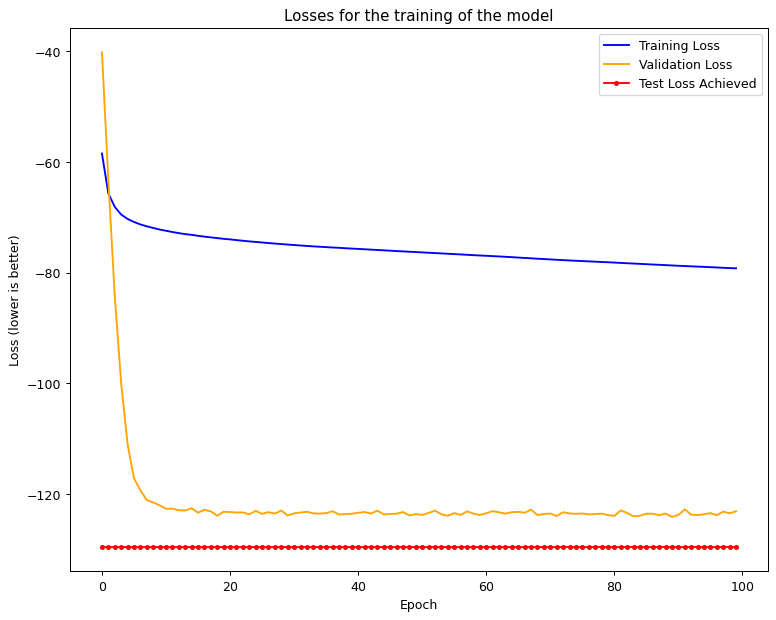

In [15]:
with open("MCA_DCCA_GridSearch_Results.pkl", "rb") as fp:   # Unpickling
    results = pickle.load(fp)

print("The nunmber of different results are: ", len(results))
print()
# each result is in the format ([training_losses], [validation_losses], test_loss, parameters):
from operator import itemgetter

best_test_loss = min(results, key=itemgetter(2))
print("The best test loss that was managed is: ", best_test_loss[2])
print("The test loss was managed with the following parameters:")
pprint.pprint(best_test_loss[3])
print()

x = np.arange(len(best_test_loss[0])) # number of epochs in training, also in validation
plt.figure(figsize=(10, 8), dpi=90)
training_losses = best_test_loss[0]
val_losses = best_test_loss[1]
plt.plot(x, training_losses, color='blue', label="Training Loss")
plt.plot(x, val_losses, color='orange', label="Validation Loss")
plt.plot(x, [best_test_loss[2]]*len(best_test_loss[0]), marker='.', color='red', label="Test Loss Achieved")
plt.title("Losses for the training of the model")
plt.xlabel("Epoch")
plt.ylabel("Loss (lower is better)")
plt.legend()
plt.show()

In [16]:
# Standard parameters that shouldn't be changed:
device = torch.device('cpu')
input_shape1 = 145 # view_1.shape[1]
input_shape2 = 10  # view_2.shape[1]
epoch_log_freq = 50
use_all_singular_values = False
apply_linear_cca = True
epoch_num = 300

parameters=best_test_loss[3]

batch_size=parameters['batch_sz']
hidden_layer_size1 = parameters['hidden_layer_size1']
hidden_layer_size2 = parameters['hidden_layer_size2']
learning_rate = parameters['learning_rate']
outdim_size = parameters['outdim']
reg_par = parameters['reg_par']
layer_sizes1 = hidden_layer_size1 + [outdim_size]
layer_sizes2 = hidden_layer_size2 + [outdim_size]

model = DeepCCA(layer_sizes1, layer_sizes2, input_shape1, input_shape2, outdim_size, use_all_singular_values, device=device).double()
solver = Solver(model, linear_cca(), outdim_size, epoch_num, batch_size, learning_rate, reg_par, device=device, epoch_log_freq=epoch_log_freq, log=True)

s_1, s_2 = data1.shape[0], data2.shape[0]
# Split the dataset into training, validation and testing (75%-15%-10%):
train1, train2 = data1[0:int(s_1 * 0.75)], data2[0:int(s_2 * 0.75)]
val1, val2 = data1[int(s_1 * 0.75):int(s_1 * 0.9)], data2[int(s_2 * 0.75):int(s_2 * 0.9)]
test1, test2 = data1[int(s_1 * 0.9):], data2[int(s_2 * 0.9):]

loss = solver.fit(train1, train2, val1, val2, test1, test2, checkpoint=None)
training_losses, val_losses = solver.get_losses()

# TODO: Save linear_cca model if needed

[ INFO : 2022-04-12 20:15:53,343 ] - DataParallel(
  (module): DeepCCA(
    (model1): MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=145, out_features=1024, bias=True)
          (1): Sigmoid()
          (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (1): Sequential(
          (0): Linear(in_features=1024, out_features=1024, bias=True)
          (1): Sigmoid()
          (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (2): Sequential(
          (0): Linear(in_features=1024, out_features=1024, bias=True)
          (1): Sigmoid()
          (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        )
        (3): Sequential(
          (0): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
          (1): Linear(in_features=1024, out_features=150, bias=True)
   

In [17]:
set_size = [0, 
            train1.size(0), 
            train1.size(0) + val1.size(0), 
            train1.size(0) + val1.size(0) + test1.size(0)]

losses, outputs = solver._get_outputs(data1, data2)
losses = np.round(losses,3)
print(losses)

print()

print(type(outputs[0]))
print(outputs[0].shape)
print(type(outputs[1]))
print(outputs[1].shape)

# Saving new features in a gzip pickled file specified by save_to
with open("DATA/MCA_DCCA_outputs.pkl", 'wb') as f:
    pickle.dump(outputs, f)

[-85.778 -85.416 -94.063]

<class 'numpy.ndarray'>
(1302, 150)
<class 'numpy.ndarray'>
(1302, 150)


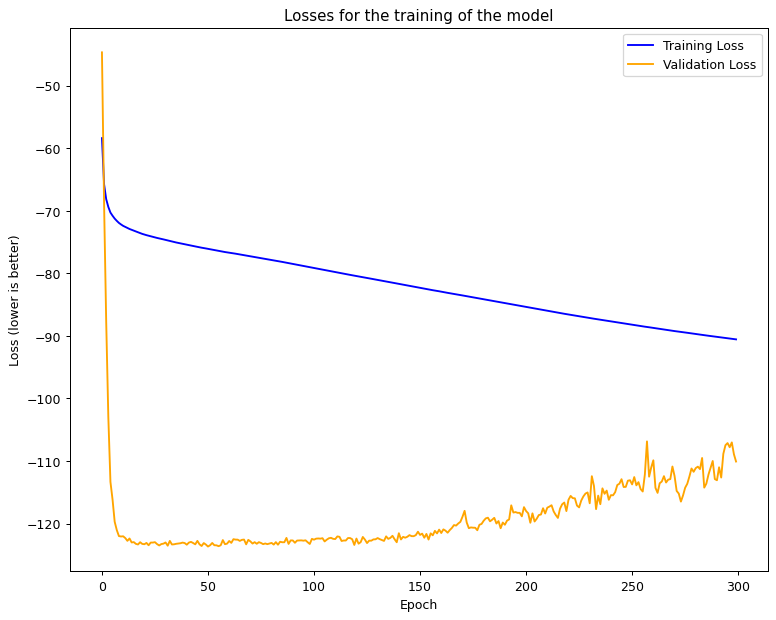

In [18]:
x = np.arange(epoch_num)
plt.figure(figsize=(10, 8), dpi=90)
plt.plot(x, training_losses, color='blue', label="Training Loss")
plt.plot(x, val_losses, color='orange', label="Validation Loss")
plt.title("Losses for the training of the model")
plt.xlabel("Epoch")
plt.ylabel("Loss (lower is better)")
plt.legend()
plt.show()

## Testing the model:

### Testing the Correlation between inputs and outputs of the deep Network:

In [20]:
from sklearn.cross_decomposition import CCA

print("CCA on input data:")
X = data1
Y = data2
cca = CCA(n_components=10)
cca.fit(X, Y)
X_c, Y_c = cca.transform(X, Y)
print(cca.score(X, Y))

print("CCA on output data:")
X = outputs[0]
Y = outputs[1]
cca = CCA(n_components=150,max_iter=10000)
cca.fit(X, Y)
X_c, Y_c = cca.transform(X, Y)
# The best possible score is 1.0 and it can be negative 
# (because the model can be arbitrarily worse)
print(cca.score(X, Y))  

CCA on input data:
0.059720376659286464
CCA on output data:
0.05021626418269462
